# Active Learning over Molecular Space
This notebook is going to show how to perform active learning to find molecules with large bandgaps.
We are going to use the [modAL](https://modal-python.readthedocs.io/en/latest/index.html) library to demonstrate a few different active learning algorithms

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from modAL.models import CommitteeRegressor
from modAL.acquisition import max_UCB
from rdkit.Chem import AllChem, DataStructs
from rdkit import Chem
from tqdm import tqdm
import pandas as pd
import numpy as np

## Load Example Data
Get the QM9 dataset from our molecular property prediction exercises.

In [2]:
data = pd.read_json('data/qm9.json.gz', lines=True)
print(f'Loaded {len(data)} molecules')

Loaded 25000 molecules


Split off some molecules to use as our initial dataset and search space

In [3]:
seed_data, search_data = train_test_split(data, train_size=8, test_size=2000)

## Build the Tools Needed for Active Learning
We first need to create a model to learn from the data we have already collected and an "oracle" that we provide the properties for a molecule on request.

### Building a KNN Model
We are going to use a simple KNN model based on the fingerprints of a molecule (see the [Chemoinformatics tutorials](https://github.com/WardLT/applied-ai-for-materials/tree/main/molecular-property-prediction)).

In [4]:
def compute_morgan_fingerprints(smiles: str, fingerprint_length: int, fingerprint_radius: int):
    """Get Morgan Fingerprint of a specific SMILES string.
    Adapted from: <https://github.com/google-research/google-research/blob/
    dfac4178ccf521e8d6eae45f7b0a33a6a5b691ee/mol_dqn/chemgraph/dqn/deep_q_networks.py#L750>
    Args:
      graph (str): The molecule as a SMILES string
      fingerprint_length (int): Bit-length of fingerprint
      fingerprint_radius (int): Radius used to compute fingerprint
    Returns:
      np.array. shape = [hparams, fingerprint_length]. The Morgan fingerprint.
    """
    # Parse the molecule
    molecule = Chem.MolFromSmiles(smiles)

    # Compute the fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(
        molecule, fingerprint_radius, fingerprint_length)
    arr = np.zeros((1,), dtype=np.bool)

    # ConvertToNumpyArray takes ~ 0.19 ms, while
    # np.asarray takes ~ 4.69 ms
    DataStructs.ConvertToNumpyArray(fingerprint, arr)
    return arr


class MorganFingerprintTransformer(BaseEstimator):
    """Class that converts SMILES strings to fingerprint vectors"""
    
    def __init__(self, length: int = 256, radius: int = 4):
        self.length = length
        self.radius = radius
    
    def fit(self, X, y=None):
        return self  # Do need to do anything
    
    def transform(self, X, y=None):
        """Compute the fingerprints
        
        Args:
            X: List of SMILES strings
        Returns:
            Array of fingerprints
        """
        fing = [compute_morgan_fingerprints(m, self.length, self.radius) for m in np.squeeze(X)]
        return np.vstack(fing)

In [5]:
model = Pipeline([
    ('fp', MorganFingerprintTransformer()),
    ('model', KNeighborsRegressor(metric='jaccard', n_jobs=-1))  # Uses the Tanimoto similarity metric
])

In [6]:
model.fit(seed_data['smiles_0'].values[:, None], seed_data['bandgap'])

Pipeline(steps=[('fp', MorganFingerprintTransformer()),
                ('model', KNeighborsRegressor(metric='jaccard', n_jobs=-1))])

We can use [bootstrap aggregation (bagging)](https://en.wikipedia.org/wiki/Bootstrap_aggregating) to get an estimate of the uncertainty of this model by first training an ensemble of models using sklearn's [BaggingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) and then assessing the variance of the models. 

*NOTE*: Bagging, in short, works by training each model on a different subset of the data.

In [7]:
model = BaggingRegressor(model, n_estimators=8)

In [8]:
model.fit(seed_data['smiles_0'].values[:, None], seed_data['bandgap'])

BaggingRegressor(base_estimator=Pipeline(steps=[('fp',
                                                 MorganFingerprintTransformer()),
                                                ('model',
                                                 KNeighborsRegressor(metric='jaccard',
                                                                     n_jobs=-1))]),
                 n_estimators=8)

In [9]:
committee = CommitteeRegressor(model.estimators_)

In [10]:
y_pred, y_std = committee.predict(search_data['smiles_0'], return_std=True)

Plot the results

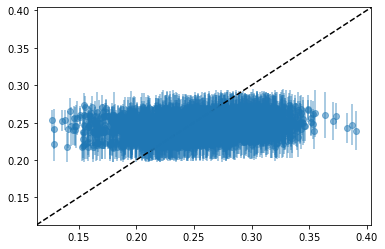

In [11]:
fig, ax = plt.subplots()

ax.errorbar(search_data['bandgap'], y_pred, fmt='o', yerr=y_std, alpha=0.5)

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

It is not a great model, but it at least gives us a starting place that is a little better than random

### Create the Oracle
The "oracle" in active learning is the tool used to gather properties for a certain data point. 
We are going to make one that is just a lookup table

In [12]:
lookup_table = dict(zip(data['smiles_0'], data['bandgap']))  # Makes a dictionary with key as a SMILES and value as a bandgap

In [13]:
def get_bandgap(smiles: str):
    """Lookup the bandgap of a model from a table
    
    Args:
        smiles: SMILES string of a molecule
    Returns:
        (float) A bandgap energy
    """
    return lookup_table[smiles]

In [14]:
get_bandgap('CC')  # Get the bandgap energy of ethane

0.44260000000000005

## Run the Active Learning Agent
The `CommitteeRegressor` we created also gives us the tools we need to run active learning. We can definte a query strategy, such as [UCB](https://modal-python.readthedocs.io/en/latest/content/query_strategies/Acquisition-functions.html#upper-confidence-bound), to pick the points and then use the regressor to determine which new point would be the best.

In [15]:
committee.query_strategy = max_UCB

Given a list of points, it will suggest the next best point to evaluate

In [16]:
point, smiles = committee.query(search_data['smiles_0'].values)

In [17]:
print(f'Selected {smiles[0]}, which is point #{point[0]} in our dataset')

Selected CC1COCC1(O)CO, which is point #263 in our dataset


We can use our Oracle to get its band gap energy

In [18]:
new_bandgap = get_bandgap(smiles[0])
print(f'{smiles[0]} has a bandgap of {new_bandgap:.2f}')

CC1COCC1(O)CO has a bandgap of 0.30


We can then add this to our training set and repeat the process. We will do that in a for loop to do it many times.

But first, let's move the data into lists for making our coding easier

In [19]:
train_X = seed_data['smiles_0'].tolist()
train_y = seed_data['bandgap'].tolist()
search_X = search_data['smiles_0'].tolist()

In [20]:
for step in tqdm(range(50)):
    # Run the query with the AI tool
    points, smiles = committee.query(search_X)
    
    # Get the value of the bandgap
    bandgaps = [get_bandgap(s) for s in smiles]
    
    # Remove that value from the search space
    search_X = np.delete(search_X, points)
    
    # Add it to the training set
    train_X.extend(smiles)
    train_y.extend(bandgaps)
    
    # Retrain the ensemble
    model.fit(np.expand_dims(train_X, axis=-1), train_y)
    
    # Reset the active learning agent
    committee = CommitteeRegressor(
        model.estimators_,
        query_strategy=max_UCB,
    )

100%|██████████| 50/50 [01:59<00:00,  2.39s/it]


Plot it compared to random selection

In [21]:
# Simulate a random search by drawing a random subset
random_selection = search_data.sample(len(train_X) - len(seed_data))
random_y = np.concatenate([seed_data['bandgap'].values, random_selection['bandgap'].values])

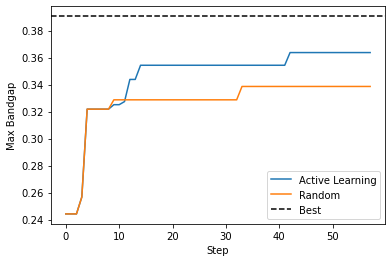

In [22]:
fig, ax = plt.subplots()

ax.plot(np.maximum.accumulate(train_y), label='Active Learning')
ax.plot(np.maximum.accumulate(seed_data['bandgap'].tolist() + random_selection['bandgap'].tolist()), label='Random')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [search_data['bandgap'].max()]*2, 'k--', label='Best')

ax.set_ylabel('Max Bandgap')
ax.set_xlabel('Step')
        
ax.legend()

We can see the active learning approach tend to do better over time but that this is not guaranteed. Each time you run this notebook, it may do better or worse.